Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [4]:
import pandas as pd

import numpy as np

import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt

import datetime

from matplotlib.ticker import FuncFormatter

import matplotlib.ticker as ticker

from scipy import stats

from tqdm.auto import tqdm

from scipy.stats import norm

from scipy.stats import mannwhitneyu

import statsmodels.api as sms

In [5]:
#Загрузим наши данные
df= pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-trudoljubova/Проект_1_Задание_2.csv', sep= ';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [6]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [7]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [8]:
#Так как мы знаем по условию, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
#При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
#Стоит проверить статистически значима разница ARPU в 5% тестовой группы над контрольной или нет!

In [9]:
#Для этого построим распределения платящих пользователей для контрольной и тестовой группы, где 
# a- контрольная группа,
# b- тестовая группа

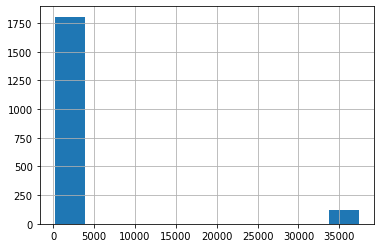

In [10]:
#Контрольная группа
df.query('testgroup == "a" and revenue > 0')['revenue'].hist()

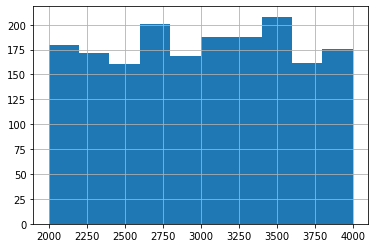

In [11]:
#Тестовая группа
df.query('testgroup == "b" and revenue > 0')['revenue'].hist()

In [12]:
#Видим, что распределения групп очень сильно различаются. 
#Обратим внимание на выбросы контрольной группы и проверим какое количество наших пользователей платит больше, чем остальные.

In [13]:
df[df.testgroup == "a"].query('revenue > 5000').user_id.count()

123

In [14]:
#Видим, что у нас совсем небольшое количество пользователей, которые готовы платить не маленькую сумму, поэмоту посмотрим какой процент выручки они занимают от наших пользователей.
round((df[df.testgroup == "a"].query('revenue > 5000') 
       .revenue.sum() / 
       df[df.testgroup == "a"].query('revenue > 0') 
       .revenue.sum()) * 100, 1) 

89.4

Сделаем небольшой вывод, распределения контрольной и тестовой группы значительно различаются. Из полученных данных, можем сказать, что в контрольной группе пользователи готовы платить небольшие суммы, но при этом имеются 123 пользователя, которые тратят большие деньги и они составляют 89.4% всей выручки! А вот в тестовой группе все пользователи готовы платить суммы до 4000. Но так как распределение контрольной группы выглядит немного странно, то следует обратиться к критерию, который устойчив к выбросам - U-критерий Манна-Уитни.

In [15]:
#Проведём тест и посмотрим на p-уровень значимости.
mannwhitneyu(df[df.testgroup == "a"].revenue,
             df[df.testgroup == "b"].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [16]:
#Посчитаем ARPU для контрольной группы.
ARPU_control= df.query('testgroup == "a"').revenue.mean()
ARPU_control

25.413719736965806

In [17]:
#Посчитаем ARPU для тестовой группы.
ARPU_test= df.query('testgroup == "b"').revenue.mean()
ARPU_test

26.75128659327863

In [18]:
#Для собственной проверки данных, посчитаем на сколько ARPU тестовой группы статистически значимо выше, чем ARPU контрольной группы 
(ARPU_test-ARPU_control)/ARPU_test*100

5.00000944496214

Сделаем небольшой ВЫВОД, с помощью U-критерия Манна-Уитни удалось определить, что pvalue = 0.06. Но хоть мы и получили уровень значимости выше порога (>0.05) – это не значит, что нулевая гипотеза верна, так как уровень значимости выше порога на совсем маленькое число. Проверим еще отдельно тест Манна-Уитни на платящих пользователях и посмотрим на результаты.

In [19]:
mannwhitneyu(df[df.testgroup == "a"].query('revenue > 0').revenue,
             df[df.testgroup == "b"].query('revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Только для платящих пользователей видим, что pvalue = 0.0 (<0.05), но чтобы нам не совершить ошибку первого рода, стоит более точно все перепроверить и в этом нам поможет бутстап, так как его результаты более точны.

In [20]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

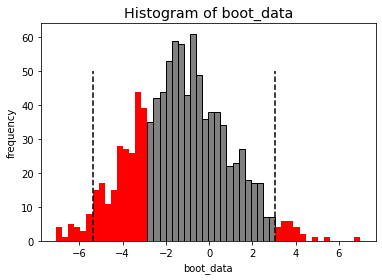

In [21]:
#ARPU
boot_df_mean = get_bootstrap(df[df.testgroup == "a"].revenue, 
                                 df[df.testgroup == "b"].revenue, 
                                 boot_it = 1000,
                                 statistic = np.mean)

In [22]:
boot_df_mean['quants']

,0
0.025,-5.370782
0.975,3.040252


In [23]:
boot_df_mean['p_value']

0.5448820537212735

Результаты pvalue = 0.50 (> 0.05), а также 0 лежит в доверительном интервале. Поэтому можно сказать, что статистически значимых различий между группами не выявлено. Проведем такой же анализ для платящих пользователей (ARPPU).

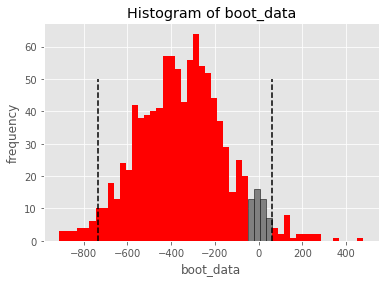

In [24]:
#ARPPU
boot_mean = get_bootstrap(df[df.testgroup == "a"].query('revenue > 0').revenue, 
                            df[df.testgroup == "b"].query('revenue > 0').revenue, 
                            boot_it = 1000 
                            )

In [25]:
boot_mean['quants']

,0
0.025,-732.830874
0.975,60.672835


In [26]:
boot_mean['p_value']

0.08954203996935327

Видим результаты pvalue = 0.12 (> 0.05) и 0 лежит в доверительном интервале. Поэтому статистически значимых различий между группами нет. На основании проведенного анализа получается, что с точки зрения выручки мы не видим разницы между данными наборами.

**ВЫВОД: В ходе проделанной работы, мы установили, что с точки зрения выручки, статистически значимого различия между контрольной и тестовой группой нет. Но зато есть различия в структурах платящих пользователей каждой из групп: в контрольной группе 89.4% выручки составляют 123 пользователя, которые платят приличные суммы, остальные пользователи платят немного. А в тестовой группе все пользователи платят от 2000 до 4000.**

**Для того, чтобы определить какой вариант считать лучшим, стоит выбрать для себя самостоятельно, так как мы выяснили, что особой разницы среди выручки нет, то тут есть 2 варианта развития событий:**

**1. работать с небольшой группой пользователей, которые платят приличные суммы и всячески стараться их удержать**

**или**

**2. работать с большим количеством пользователей, которые будут платить стабильно от 2000 до 4000.**

**Очень многое будет зависеть от данного выбора, так как предложения для двух данных групп будут различными. Как по мне, лучше выбрать 2 вариант, где пользователи будут платить стабильно, хоть и не самые крупные суммы, чем рискнуть и потерять свою прибыль за счет небольшой, но с хорошими чеками, группы.**